# Chapter 3: Charlie signs up for Petflix

### Quick Start

If you are in the colab environment, please follow the steps below:

Step 1: Click Runtime -> Run all to run the notebook.

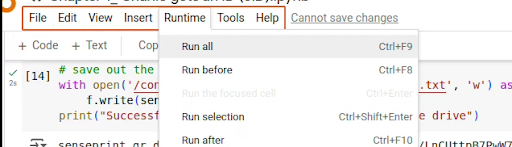

Step 2: You will be prompted to give permission to access your Google Drive files, which is essential for the notebook to save intermediate results. Please click on "Connect to Google Drive".

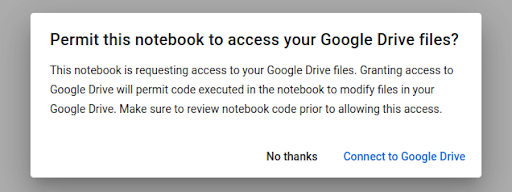

Step 3: Please click on "Run anyway" to run the notebook!

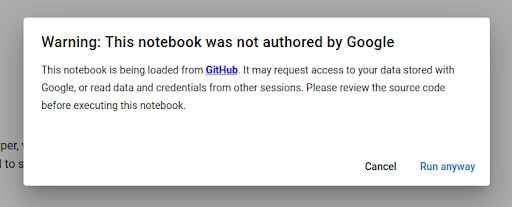

As an alternative to run all cells, you can also run cell by cell and give aforementioned permissions when prompted!

### 3.1 Overview
1. [Chapter 1_ Charlie gets an ID (eID)](https://colab.research.google.com/github/Seventh-Sense-Artificial-Intelligence/SenseCrypt-Walkthrough/blob/main/Chapter%201_%20Charlie%20gets%20an%20ID%20(eID).ipynb)
1. [Chapter 2_ Charlie wants a loan (eID)](https://colab.research.google.com/github/Seventh-Sense-Artificial-Intelligence/SenseCrypt-Walkthrough/blob/main/Chapter%202_%20Charlie%20wants%20a%20loan%20(eID).ipynb)
1. [Chapter 3_ Charlie signs up for Petflix (FacePKI)](https://colab.research.google.com/github/Seventh-Sense-Artificial-Intelligence/SenseCrypt-Walkthrough/blob/main/Chapter%203_%20Charlie%20signs%20up%20for%20Petflix%20(FacePKI).ipynb)
1. [Chapter 4_Charlie_signs into Petflix (FacePKI)](https://colab.research.google.com/github/Seventh-Sense-Artificial-Intelligence/SenseCrypt-Walkthrough/blob/main/Chapter%204_Charlie_signs%20into%20Petflix%20(FacePKI).ipynb)
1. [Chapter 5_Petflix sends Charlie a catbond meme (FacePKI)](https://colab.research.google.com/github/Seventh-Sense-Artificial-Intelligence/SenseCrypt-Walkthrough/blob/main/Chapter%205_Petflix%20sends%20Charlie%20a%20catbond%20meme%20(FacePKI).ipynb)
1. [Chapter 6_Charlie decrypts catbond meme (FacePKI)](https://colab.research.google.com/github/Seventh-Sense-Artificial-Intelligence/SenseCrypt-Walkthrough/blob/main/Chapter%206_Charlie%20decrypts%20catbond%20meme%20(FacePKI).ipynb)

### 3.2 Introduction

Charlie Cryptofson had a soft spot for animals. Whether it was the playful antics of kittens or the majestic flight of eagles, he couldn’t get enough of the animal kingdom. After a long day of zooming through the streets of Cryptoville in his new sports car, Charlie liked to unwind with something comforting. That’s when he discovered Petflix, the streaming service dedicated to all things animals. From documentaries about wild creatures to cute compilations of puppies, Petflix had it all—and Charlie knew it was exactly what he needed. Excited to dive into this new world of furry, feathered, and scaly friends, Charlie quickly signed up for an account, eager to explore the endless entertainment awaiting him. <br><br>

**Flow of Events:**
1. Verifier (Petflix) generates an attributes key pair. This attributes key pair is used for encrypting eID attributes.
1. Verifier sends the attributes public key to the Trusted Issuer (Government).
1. Trusted Issuer (Government- mobile app) creates a Face Certificate of Charlie using his face, his SensePrint, and a purpose_id, and the attributes public key.
1. Trusted Issuer sends the Face Certificate over to the Verifier.
1. Verifier verifies user's Face Certificate by sending a request to the Sensecrypt server.
1. If successfully verified, the metadata is also returned.
1. Verifier can successfully verify user identity and access his authenticated metadata.

Note that only the Trusted Issuer sees the user's face. The Verifier does not access the biometric data of the user throughout the whole process.

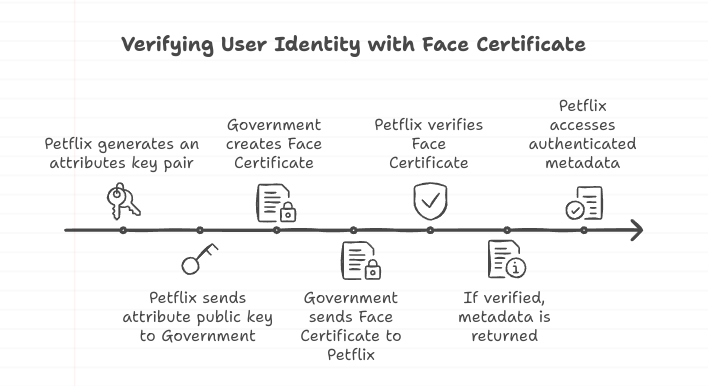

### 3.3 Problem Statements

**Problem 1:**

>However, due to a new regulation introduced in Cryptoville, private companies are no longer allowed to access the face/biometric data of customers. This caused a new problem to arise. Petflix can't have access to Charlie's face. **How can Petflix verify the identity of Charlie without having access to his face?**

>Also, Petflix would need several details about Charlie, namely his name, age, date of birth, citizenship and address. His citizenship is required so that Petflix can log him into the correct country. His age to ensure that he is old enough for some videos (gory animal hunting scenes etc.) and his birthday so that Petflix can send him promotions on his birthday month. His name and address are used for billing purposes. **How can Petflix verify his details without access to his face/biometric data?** *Hint: Recall earlier that these attributes are stored in our SensePrint created in Chapter 1.*

**Problem 2:**

>Another big issue facing Petflix is account sharing, where multiple people log in to the same account. **Petflix needs a way to ensure that every login is from Charlie himself.** This is costing Petflix billions in revenue yearly. Let's see how we can solve this issue using the SenseCrypt Face Public Key Infrastructure.

**Introducing SenseCrypt Face Public Key Infrastructure, a world-first technology that allows Petflix to verify the identity of Charlie without access to his face using something known as the Face Certificate. Let's see how this works!**

### 3.4 Pre-run cells

In [6]:
# **********************************INPUT************************************#
# Please provide the url of the SenseCrypt server and the associated api key.#
# ***************************************************************************#
url = "https://apiserver.sensecrypt.com/"
api_key = "BjeaACQczWh5Xw5sIEE0mBu1mpCnfOfmM47PT67f7mw="

In [7]:
# Run these helper functions, which will be used later in the notebook
from io import BytesIO
import base64
import requests
import cv2
import matplotlib.pyplot as plt
from PIL import Image

using_colab = True
try:
    # mount your private google drive for saving and loading out artifacts to be used in subsequent notebooks
    from google.colab import drive
    drive.mount('/content/drive')
except ImportError:
    print("Not in Google Colab. Assume running in the local environment and not accessing google drive storage.")
    import os
    using_colab = False

def call_sensecrypt_server(api_key, data, endpoint, url):

    full_url = url + endpoint

    # Prepare headers
    headers = {
        "x-api-key": api_key,
        "Content-Type": "application/json"
    }

    # Send POST request
    response = requests.post(full_url, json=data, headers=headers)

    # Check the response status and content
    if response.status_code == 200:
        print("Request was successful")
        return response  # Return JSON data if the request was successful
    else:
        print(f"Request failed with status code: {response.status_code}")
        print(response.text)  # Print the raw response content
        return None

def convert_image_to_base64(image, format="JPEG"):

    # Save the image as a byte stream in memory
    buffered = BytesIO()
    image.save(buffered, format=format)  # Default format is 'JPEG', can be changed
    img_bytes = buffered.getvalue()

    # Convert byte stream to Base64
    img_base64 = base64.b64encode(img_bytes).decode('utf-8')

    return img_base64

def fetch_image(image_url):
  response = requests.get(image_url)
  img = Image.open(BytesIO(response.content))
  return img

Not in Google Colab. Assume running in the local environment and not accessing google drive storage.


### 3.5 Setting up the attributes key pair for encrypting the eID attributes (Optional)

Before using the SenseCrypt Public Key Infrastructure (PKI), Petflix needs to generate an attributes key pair to encrypt the eID attributes. While this step is optional, for our example, we will encrypt Charlie’s eID attributes to protect his sensitive data.

**What Are eID Attributes?**

>The eID attributes refer to the metadata stored within the SensePrint. This is also known as the SensePrint eID attributes. This metadata can also be selectively chosen and stored within the generated Face Certificate, as the SensePrint is used to create the Face Certificate. These selected attributes are then known as the Face Certificate eID attributes. There is an option to encrypt the Face Certificate eID attributes during the Face Certificate generation process.
>When generating the Face Certificate using the `/generate-face-certificate` endpoint, the attributes public key is provided to encrypt these Face Certificate eID attributes.

**Since eID attributes are already stored within the SensePrint, why do we need to store/encrypt again in the Face Certificate?**

> The SensePrint eID attributes can only be accessed with the user's face. This mean that everytime someone wants to access the SensePrint eID attributes, the user needs to be present.

> The Face Certificate can be used without the user's face to access the Face Certificate eID attributes. Petflix, with the attributes private key, can access the eID attributes without the user's face.

**What is happening behind the scenes?**

> Behind the scenes, the `/generate-face-certificate` endpoint uses the user's face to access the SensePrint eID attributes. It then references the SensePrint eID attributes to selectively create it's own copy of the Face Certificate eID attributes. If a `attribute_encryption_secp256k1_public_key_base64` is provided, it will then use this public key to encrypt the Face Certificate eID attributes.

**Key Pair Generation**

>Below, we will guide you through the process of generating this attributes key pair. In our example:
>The attributes private key is securely stored by the verifier (Petflix).
>The attributes public key is shared with the issuer (Government).
>Additionally, the attributes public key can be shared with any person responsible for generating the Face Certificate.

In [14]:
# The verifier (Petflix) has to generate a Secp256k1 Key Pairs (for eID attribute encryption)
# The attributes public key that is generated will be sent to the issuer (government)
# to encrypt the eID information when generating the Face Certificate.
# This is optional but needed in this use case since we do not want to expose the metadata
# of Charlie over the internet.

# On the Petflix server, the following command can be used to generate the key pairs
import subprocess
import time

# Install openssl if not already installed
# If you are on a local Linux system and see permission denied error, 
# consider using `sudo` command in the command line to install openssl.
!apt update -y
!apt install openssl -y

if using_colab:
    key_outdir = "/content/drive/My Drive/secp256k1-key.pem"
else:
    os.makedirs("./temp/Chapter3/", exist_ok=True)
    key_outdir = "./temp/Chapter3/secp256k1-key.pem"

command = f"""
openssl ecparam -name secp256k1 -genkey -noout -out "{key_outdir}" && # Generate the key pair
openssl ec -in "{key_outdir}" -pubout -conv_form compressed -outform DER | # Extract the public key in DER format
tail -c 33 | openssl base64
"""

# Run the command using subprocess to generate the attributes public key and capture the output
result = subprocess.run(command, shell=True, executable='/bin/bash', capture_output=True, text=True)

# Store the attributes public key in a variable
public_key = result.stdout.strip()

# Define the command to extract the attributes private key in DER format and convert it to base64
private_key_command = f"""
openssl ec -in "{key_outdir}" -outform DER |
tail -c +8 | head -c 32 | openssl base64
"""

# Run the command using subprocess to generate the attributes private key and capture the output
private_key_result = subprocess.run(private_key_command, shell=True, executable='/bin/bash', capture_output=True, text=True)

# Store the attributes private key in a variable
private_key = private_key_result.stdout.strip()

# Print both the public and private keys
print("-----------------------------------")
print("Attributes Public Key:", public_key)
print("")
print("Attributes Private Key:", private_key)

-----------------------------------
Attributes Public Key: ArwGqggCjLP0gEew/h2qIeO+ikFNnHkKK4x8wrToWTle

Attributes Private Key: 3AWBsfL80NJSJJ6do4SQ9maVu1s9I0z6Z5T4DWa4lhY=


### 3.6 Using the `/generate-face-certificate` API Endpoint [(Link to documentation)](https://docs.sensecrypt.com/sensecrypt-v3.1.1/sensecrypt-server/sensecrypt-face-pki/generate-your-first-face-certificate)

**Generating the SenseCrypt Face Certificate**

>During the sign-up process on Petflix, the website prompts Charlie to generate his own SenseCrypt Face Certificate using the Government mobile app. Once the Face Certificate is generated, it can be securely transmitted and stored in the Petflix database. This guide assumes that the generated Face Certificate will be securely transferred from the government servers to the Petflix servers.

**Understanding the eID Attributes**

>As previously mentioned, Petflix requires Charlie's personal information—name, age, date of birth, address, and citizenship. These attributes, also known as eID attributes, are sensitive and must be encrypted to prevent unauthorized access. To ensure privacy, these eID attributes need to be encrypted using the key pair generated earlier.

>Recall that these attributes were originally stored in the SensePrint, created in Chapter 1. When generating the Face Certificate, the same eID attributes are selectively stored within it.

**Encrypting the eID Attributes Using the Key Pair**

>Now that we have generated the private-public attributes key pair, we can use them to encrypt the eID attributes during the generation of the Face Certificate. The following code is made from the Government mobile app (built on top of the SenseCrypt SDK).

*Note: Custom apps can be built on top of the SenseCrypt mobile SDK to access the SenseCrypt server API endpoints. What is shown here are the raw API calls made through the SenseCrypt mobile SDK in order to aid your understanding of the overall process flow.*


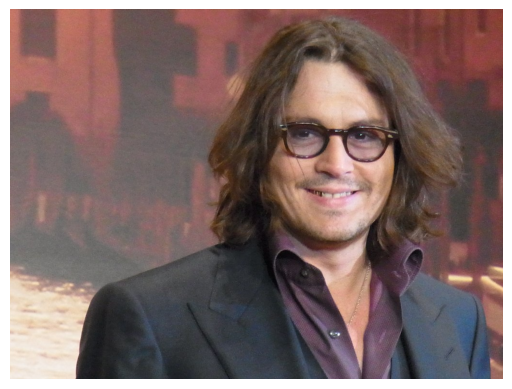

/9j/4AAQSkZJRgABAQAAAQABAAD/2wBDAAgGBgcGBQgHBwcJCQgKDBQNDAsLDBkSEw8UHRofHh0aHBwgJC4nICIsIxwcKDcpLDAxNDQ0Hyc5PTgyPC4zNDL/2wBDAQkJCQwLDBgNDRgyIRwhMjIyMjIyMjIyMjIyMjIyMjIyMjIyMjIyMjIyMjIyMjIyMjIyMjIyMjIyMjIyMjIyMjL/wAARCAMABAADASIAAhEBAxEB/8QAHwAAAQUBAQEBAQEAAAAAAAAAAAECAwQFBgcICQoL/8QAtRAAAgEDAwIEAwUFBAQAAAF9AQIDAAQRBRIhMUEGE1FhByJxFDKBkaEII0KxwRVS0fAkM2JyggkKFhcYGRolJicoKSo0NTY3ODk6Q0RFRkdISUpTVFVWV1hZWmNkZWZnaGlqc3R1dnd4eXqDhIWGh4iJipKTlJWWl5iZmqKjpKWmp6ipqrKztLW2t7i5usLDxMXGx8jJytLT1NXW19jZ2uHi4+Tl5ufo6erx8vP09fb3+Pn6/8QAHwEAAwEBAQEBAQEBAQAAAAAAAAECAwQFBgcICQoL/8QAtREAAgECBAQDBAcFBAQAAQJ3AAECAxEEBSExBhJBUQdhcRMiMoEIFEKRobHBCSMzUvAVYnLRChYkNOEl8RcYGRomJygpKjU2Nzg5OkNERUZHSElKU1RVVldYWVpjZGVmZ2hpanN0dXZ3eHl6goOEhYaHiImKkpOUlZaXmJmaoqOkpaanqKmqsrO0tba3uLm6wsPExcbHyMnK0tPU1dbX2Nna4uPk5ebn6Onq8vP09fb3+Pn6/9oADAMBAAIRAxEAPwC4R1Oc0zqcZHBqRiM9PxNNcAEEEenArzVufRszbsYRl6Cs1zjA4wfxrTu8HIA4xjB/xrMbGSMYxwMmuiK0OWoMPUnA6Ub8KBgcnJIpDk5ORjGOe49aRVOMe/WrMNbgSWzTsjrj2/CggHhTyOSDTQMbiT780rDuKwIBOePQ0ZAy

In [9]:
import matplotlib.pyplot as plt

# Load the image from file.
# In actual implementation, this will be the image captured by the user (Charlie) using the phone camera from within the Government app
# Load the image from link
if using_colab:
    image = fetch_image("https://raw.githubusercontent.com/Seventh-Sense-Artificial-Intelligence/SenseCrypt-Walkthrough/refs/heads/main/images/JohnnyDepp_2.jpg")
else:
    image = Image.open("./images/JohnnyDepp_2.jpg")
plt.imshow(image)
plt.axis("off")
plt.show()
img_base64 = convert_image_to_base64(image)
print(img_base64)

In [10]:
# Retrieve the Senseprint
# This Senseprint is retrieved from the Government servers via the Government mobile app.
# Here, we load the the Senseprint from a file to simulate.

if using_colab:
    senseprint_filepath = '/content/drive/My Drive/senseprint_qr_data.txt'
else:
    senseprint_filepath = './temp/Chapter1/senseprint_qr_data.txt'
    assert os.path.exists(senseprint_filepath), 'SensePrint QR data does not exist! Please generate the qr data by running the chapter 1 notebook :)'

with open(senseprint_filepath, 'r') as file:
    senseprint_base_64 = file.read()

print("senseprint_base_64:", senseprint_base_64)


senseprint_base_64: ApiBrQakACi6TZNNwJhDjtmDkvjWSewfiTY72rs3IVI+8g3l6sDheWxfi+A8zxRkQD2OckLMMfobbRSEmtWO+VRIO21JPYB18NV/MfLgmrjZrfqihqj+tuwYwhtRGD4kZoygdtkOAtpJGouSQv87nqYZKOH3V8sJ/kDOl1fCVHZhYnisnKP10TPSFo6cfVGtw28167iAjdeO4+CutWwYeckLSNU+vQ7c95LKLgc/hyc71x1+zmcNQ/2Gy/0MTtLQrxKKk82H0AjcDGstbjW2vFl4NNTk/WAZXsBOn4rpRauKgwN06xoQ738QSEBvKTFBmTngYcUytAw/vRCmvvxqz6QDGIi3PCfjejlGOhsOgZBr2+/9YpLeqHSwiOCpIOJuA89bZTHBirLzR62kQtUAagz0H8795x3Qa8siLxMpPTVneHfeWCorTHmxA2kgE7UZ52Q76rw+0jAE56ZkptnE7mJxdf4+QvQm33R8BiQIZizQgcCc/q6aXEyHGKn6JWq8CAKd20HUjftigVXOMrf8AOUpQSB5UKzLOxYKX6lhbOZedQIMmhBp0P+GZuAq3392o5V8F1IFaLOz0c458z4HrbFfXN9n8h9twer7cOA6HoaNhMIyVCf+Hc/wlkThKK0NHKiFeR9YIXrm2L2AMEGXbZWsIdj5/BYOwnhjjjjEC9Tax32YqVYyQAwOZCOiCcHggkDCoy6UFZ/SXND03kUg2hmIoZjZOqE87e4Aktb2XT5KNmEZN613uvCM2iSl618D9NUH8Mlg


>**A note on SensePrint:** Since the SensePrint is itself not linkable back to the any individual persons, it can be shared freely. In this case, both the Government and Petflix can store the generated SensePrint.

In [11]:
# Now that the senseprint has been created, the next step is to generate the Face Certificate
data = {
    "face_base_64": img_base64,
    "expiration_date_utc": "2034-10-01T00:00:00Z",
    "senseprint_base_64": senseprint_base_64,
    "purpose_id": "for_petflix_login_and_decryption",
    "attribute_encryption_secp256k1_public_key_base64": public_key,
    # expose the Senseprint eID attributes that we want to include in the Face Certificate
    "requested_attributes": ["name",
                            "age",
                            "date_of_birth",
                            "address",
                            "citizenship"],
    "user_subject_name": "charlie_cryptofson@example.com",
    "check_live_face_before_creation": True
}

endpoint = "/generate-face-certificate"

response = call_sensecrypt_server(api_key, data, endpoint, url)

face_cert = response.json()["cert_pem"]
print("face_cert_pem:", face_cert)

# save the face certificate to a file for later use in the next chapter
# The generated face certificate will be used by the verifier (Petflix) for log in and to decrypt the eID information
if using_colab:
    with open("/content/drive/My Drive/face_cert.pem", "w") as f:
        f.write(face_cert)
else:
    os.makedirs("./temp/Chapter3/", exist_ok=True)
    with open("./temp/Chapter3/face_cert.pem", "w") as f:
        f.write(face_cert)

Request was successful
face_cert_pem: -----BEGIN CERTIFICATE-----
MIICXjCCAgSgAwIBAgIRAPGlGkF7fsf3BjeW+RG3KJEwCgYIKoZIzj0EAwIwSDFG
MEQGA1UEAww9U2Vuc2VDcnlwdCBDdXN0b21lciBJRCAoYTZiNDQ5MzQtN2Q0Yi00
OWFlLWI4MjQtMDBmZWQ2MjU1ZmY2KTAeFw03MDAxMDEwMDAwMDBaFw0zNDEwMDEw
MDAwMDBaMCkxJzAlBgNVBAMMHmNoYXJsaWVfY3J5cHRvZnNvbkBleGFtcGxlLmNv
bTBWMBAGByqGSM49AgEGBSuBBAAKA0IABH/LdqeOluQBQBJssuo01MZMFr+rhRQf
7aMt0qqHQ/rr247QHIxxt/52tMmUTwHyJIZt6LsbilkZrTOcYw5lygajgfAwge0w
DgYDVR0PAQH/BAQDAgWgMIHaBgoqhT4Ah3QBAQEABIHLAs81kKhZYimRYfjF4oFG
880VOaIVxFBIMe4pL6+CeSWPmXiOW56UzKUVJxfHpRacNL3UvGu9BH9lkEqy+Tyg
j647/BKbqpXlKVr3iJNanPelKyZW0XiM5u6RWwz+dVJdtUNJEnNU90x9rxr9qZNk
yHbUIRVvkA0yChSB7hLVPCGqMK2/B32+S6Q2PdpizsD136LXRN5XgUqWXyuxRlR6
x0Cg9wnnDJXlfqRZQHKMWYivlJS1EyjXQFnf4XRJ9Q/2ovJeUcBWahM+ymYwCgYI
KoZIzj0EAwIDSAAwRQIgBPm+vguS/++PajRX2D9GXsUSIsX0JGqG0qMW90c2jmEC
IQDs5J9+bMTvQQq8wk+tMrk4TxygLR+zwuS5367e0/LS4w==
-----END CERTIFICATE-----



### 3.7 Using the `/verify-face-certificate` API endpoint [(Link to documentation)](https://docs.sensecrypt.com/sensecrypt-v3.1.1/sensecrypt-server/sensecrypt-face-pki/verifying-a-face-certificate)

After the Face Certificate generated is being the Government app, it is then securely sent to the Petflix servers from the app itself. Petflix servers now have the generated Face Certificate. Do note that now, both the Government (Trusted Issuer) and Petflix (Verifier) have the Face Certificate.<br><br>

With the Face Certificate, Petflix can verify the Face Certificate against the SenseCrypt servers to verify the identity of Charlie **without** having access to his face/biometrics. In addition, Petflix can view the **verified** eID attributes stored within the Face Certificate in order to retrieve the name, age, date of birth, address and citizenship of Charlie. Note that since the attributes private key is only available to Petflix (and optionally sent to the Trusted Issuer), others with the same Face Certificate will not be able to see the eIDs, which are encrypted.<br><br>

Petflix servers use the `/verify-face-certificate` endpoint. We shall see how it works now.

In [12]:
data = {
    "cert_pem": face_cert,
    # "secp256k1_private_key_base64": private_key, # optional. Will also decrypt the stored encrypted metadata
}

endpoint = "/verify-face-certificate"

response = call_sensecrypt_server(api_key, data, endpoint, url)
metadata = response.json()['metadata']
print("metadata:", metadata)
secp256k1_public_key_base64 = response.json()["secp256k1_public_key_base64"]
print(secp256k1_public_key_base64)

# Now that the request was successful, the Face Certificate has been verified.
# If the request is not successful, the api would return a verification failed error msg

Request was successful
metadata: As81kKhZYimRYfjF4oFG880VOaIVxFBIMe4pL6+CeSWPmXiOW56UzKUVJxfHpRacNL3UvGu9BH9lkEqy+Tygj647/BKbqpXlKVr3iJNanPelKyZW0XiM5u6RWwz+dVJdtUNJEnNU90x9rxr9qZNkyHbUIRVvkA0yChSB7hLVPCGqMK2/B32+S6Q2PdpizsD136LXRN5XgUqWXyuxRlR6x0Cg9wnnDJXlfqRZQHKMWYivlJS1EyjXQFnf4XRJ9Q/2ovJeUcBWahM+ymY=
-----BEGIN PUBLIC KEY-----
MFYwEAYHKoZIzj0CAQYFK4EEAAoDQgAEf8t2p46W5AFAEmyy6jTUxkwWv6uFFB/t
oy3SqodD+uvbjtAcjHG3/na0yZRPAfIkhm3ouxuKWRmtM5xjDmXKBg==
-----END PUBLIC KEY-----



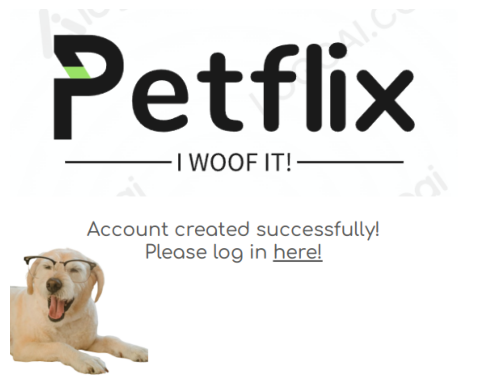

In [13]:
if using_colab:
    image = fetch_image("https://raw.githubusercontent.com/Seventh-Sense-Artificial-Intelligence/SenseCrypt-Walkthrough/refs/heads/main/images/petflix_account_created.png")
else:
    image = Image.open("./images/petflix_account_created.png")
plt.imshow(image)
plt.axis("off")
plt.show()

**Verifying Charlie's Identity and Attributes with the Face Certificate**
>With the Face Certificate verified, Petflix can now verify Charlie's identity and get the **verified** eID attributes such as Charlie's name, age, date-of-birth, citizenship and address. This solves the first problem statement. Petflix was able to trust the data received without having witnessed his photo/ biometric data. A win for all!

**Addressing the Second Problem: Secure Login**
>For the second problem statement, we shall see in the next chapter how Petflix uses the Face Cetificate to ensure that only Charlie is the one logging into his account. Essentially, Petflix requests for Charlie to sign a `transaction-id` using the Face Certificate to generate a Face Signature. Petflix then checks this Face Signature to verify that it is really Charlie logging in. Let's dive deeper in the next chapter!

Continue on to Chapter 4: Charlie signs in to his Petflix account [here](https://colab.research.google.com/github/Seventh-Sense-Artificial-Intelligence/SenseCrypt-Walkthrough/blob/main/Chapter%204_Charlie_signs%20into%20Petflix%20(FacePKI).ipynb)!